# Drawing Insights with Big Query ML

Google Big Query is a managed, scalable data warehouse that enables analysis over large sets of data.  Big Query ML extends this functionality by enabling the use of Machine Learning with a standard SQL language by easily allowing you to train models, evaluate, and predict.

A model in Big Query ML represents what an ML System has previously learned from training data.  
There are many types of models supported such as:
- Linear regression
- Binary logistic regression
- Multiclass logistic regression
- K-means clustering 
- Matrix Factorization
- Time series
- Boosted Tree 
- Deep Neural Network 
- AutoML Tables 
- TensorFlow 

#### Lab: Getting Started in Big Query ML with Linear Regression

In this lab we will look at using NOAA temperature data for a set of years to predict future average temperature values using [Linear Regression.](https://en.wikipedia.org/wiki/Linear_regression#:~:text=In%20statistics%2C%20linear%20regression%20is,is%20called%20simple%20linear%20regression.)

1) First we will create a dataset to store the model. [Click here to open the Big Query UI](https://console.cloud.google.com/bigquery?_ga=2.44329517.868398427.1595536877-1775816527.1575499949)

2) Click your project name, which begins with `cal-`, in the lower left under `Resources`

![Project name](./assets/lab10/lab10_selectproject.png)

3) Click `Create Dataset` 

![create dataset](./assets/lab10/lab10_createdataset.png)

4) Name the dataset `bigqueryml_ca` and click `Create dataset`.

5) Next we will train our linear regression model using the code block below. This model is trained to predict on the `Temp_f` column.

In [29]:
%%bigquery
CREATE OR REPLACE MODEL
  `bigqueryml_ca.temperature_model`
OPTIONS
  ( model_type='linear_reg',
    data_split_method='NO_SPLIT',
    input_label_cols=['Temp_f'],
    max_iterations=15) AS
SELECT AVG(b.temp) as Temp_f, cast(b.year as int64) as year
FROM `bigquery-public-data.noaa_gsod.stations` a
JOIN `bigquery-public-data.noaa_gsod.gsod*` b
ON a.usaf=b.stn AND a.wban=b.wban 
WHERE a.country='US' and a.state='AK' AND b.year > '1970' AND b.year < '2020'
Group By b.year, a.state

""


6) Create and populate a table to evaluate the data against an unknown set years to see how the model predicts the result. 

In [52]:
%%bigquery
CREATE TABLE bigqueryml_ca.sample_data (
year INT64,
)

""


In [53]:
%%bigquery
INSERT bigqueryml_ca.sample_data (year) VALUES(2020);

INSERT bigqueryml_ca.sample_data (year) VALUES(2030);

INSERT bigqueryml_ca.sample_data (year) VALUES(2040);

INSERT bigqueryml_ca.sample_data (year) VALUES(2050);

INSERT bigqueryml_ca.sample_data (year) VALUES(2060);


""


Due to a Big Query Restriction on insert statements, please wait 10 sec and execute the next block.

In [54]:
%%bigquery
INSERT bigqueryml_ca.sample_data (year) VALUES(2070);

INSERT bigqueryml_ca.sample_data (year) VALUES(2080);

INSERT bigqueryml_ca.sample_data (year) VALUES(2090);

INSERT bigqueryml_ca.sample_data (year) VALUES(2100);

INSERT bigqueryml_ca.sample_data (year) VALUES(2110);

""


Next we can determine how our table evalutes against the full set of NOAA weather data for the State of Alaska.  This provides details like r^2 and mean absolute error.  The R^2 value tells us how well our model fits our data.

In [73]:
%%bigquery
SELECT * FROM
ML.EVALUATE(
  MODEL `bigqueryml_ca.temperature_model`,
  # Table to evaluate against
  (
    SELECT AVG(b.temp) as Temp_f, cast(b.year as int64) as year
    FROM `bigquery-public-data.noaa_gsod.stations` a
    JOIN `bigquery-public-data.noaa_gsod.gsod*` b
    ON a.usaf=b.stn AND a.wban=b.wban 
    WHERE a.country='US' and a.state='AK' AND b.year < '2020'
    Group By b.year, a.state
  )
)

,mean_absolute_error,mean_squared_error,mean_squared_log_error,median_absolute_error,r2_score,explained_variance
0,2.337384,12.880044,0.018,1.571725,0.011046,0.059528


7) Finally predict the average temp_f based on a set of years in the `sample_data` table.

In [55]:
%%bigquery
SELECT
  *
FROM
  ML.PREDICT (MODEL `bigqueryml_ca.temperature_model`,
    (
    SELECT year
    FROM `bigqueryml_ca.sample_data`
  ) 
)

ORDER BY year asc

,predicted_Temp_f,year
0,35.201994,2020
1,36.301745,2030
2,37.401496,2040
3,38.501247,2050
4,39.600998,2060
5,40.700749,2070
6,41.800500,2080
7,42.900251,2090
8,44.000002,2100
9,45.099753,2110


We can see the average temperature is trending upwards for the State of Alaska. 

Finally we will save the dataset for average temperature vs years into a dataframe, and then add in the machine learning result.  We will combine the data into a data frame and plot the data to observe the linear regression visually.

In [69]:
%%bigquery avg_temperature
SELECT AVG(b.temp) as Temp_f, cast(b.year as int64) as year
FROM `bigquery-public-data.noaa_gsod.stations` a
JOIN `bigquery-public-data.noaa_gsod.gsod*` b
ON a.usaf=b.stn AND a.wban=b.wban 
WHERE a.country='US' and a.state='AK' AND b.year < '2020'
Group By b.year, a.state

In [85]:
%%bigquery mlresult
SELECT
  year, predicted_Temp_f as Temp_f
FROM
  ML.PREDICT (MODEL `bigqueryml_ca.temperature_model`,
    (
    SELECT cast(b.year as int64) as year
    FROM `bigquery-public-data.noaa_gsod.stations` a
    JOIN `bigquery-public-data.noaa_gsod.gsod*` b
    ON a.usaf=b.stn AND a.wban=b.wban 
    WHERE a.country='US' and a.state='AK' AND b.year < '2020'
    ) 
)


In [86]:
import pandas as pd
frames = [avg_temperature, mlresult]
result = pd.concat(frames)

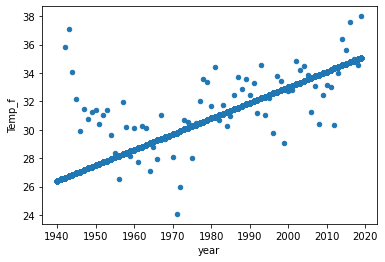

In [87]:
%matplotlib inline
result.plot(kind='scatter', x='year', y='Temp_f');

Modify the code blocks above to find your own insights in the NOAA dataset!

#### Lab: Exploring Binary Logistic Regression in Big Query ML

The next algorithm we will look at is Binary Logistic Regression which is used to predict the odds of an event outcome based on a set of independent variables.  For this example we will look at Census data as it pertains to income bracket vs several other independent variables.  For this example we will split the dataset into 4 chunks, where we train the model on 3 of them and evaluate on the last.  We use the `FARM_FINGERPRINT` function to create a hash on each row, limited to one of four chunks.

1) First train the model to target based on `income_bracket` -- Note the namespace of where we create the model is the same as above.


In [113]:
%%bigquery
CREATE OR REPLACE MODEL
  `bigqueryml_ca.census_log_reg`
OPTIONS
  ( model_type="logistic_reg",
    input_label_cols=["income_bracket"] ) AS
SELECT
  * EXCEPT(DATASET_ID)
FROM (
  SELECT
    ABS(MOD(FARM_FINGERPRINT(CONCAT( CAST(age AS STRING), CAST(education AS STRING), CAST(marital_status AS STRING), CAST(race AS STRING), CAST(sex AS STRING), CAST(income_bracket AS STRING), CAST(occupation AS STRING), CAST(capital_gain AS STRING), CAST(functional_weight AS STRING))),4)) AS DATASET_ID,
    education, marital_status, race, sex, income_bracket
  FROM
    `bigquery-public-data.ml_datasets.census_adult_income` )
WHERE
  DATASET_ID IN (0,1,2)

""


2) Once again lets evaluate how our model performed. This time we have selected a `DATASET_ID=3` which is our evaluation dataset.

In [114]:
%%bigquery
SELECT * FROM
ML.EVALUATE(
  MODEL `bigqueryml_ca.census_log_reg`,
  # Table to evaluate against
  (
    SELECT * EXCEPT(DATASET_ID)
    FROM (
      SELECT
        ABS(MOD(FARM_FINGERPRINT(CONCAT( CAST(age AS STRING), CAST(education AS STRING), CAST(marital_status AS STRING), CAST(race AS STRING), CAST(sex AS STRING), CAST(income_bracket AS STRING), CAST(occupation AS STRING), CAST(capital_gain AS STRING), CAST(functional_weight AS STRING))),4)) AS DATASET_ID,
        education, marital_status, race, sex, income_bracket
       FROM
        `bigquery-public-data.ml_datasets.census_adult_income` )
    WHERE DATASET_ID = 3
))


,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,0.729508,0.418495,0.822731,0.531873,0.383854,0.846077


3) Predict based on the evaluation set.  Below we will look at what results were predicted to have an income > 50K and less than or equal to 50K.

In [115]:
%%bigquery

## > 50K result

SELECT * FROM
ML.PREDICT(
  MODEL `bigqueryml_ca.census_log_reg`,
  # Table to evaluate against
  (
    SELECT * EXCEPT(DATASET_ID)
    FROM (
      SELECT
        ABS(MOD(FARM_FINGERPRINT(CONCAT( CAST(age AS STRING), CAST(education AS STRING), CAST(marital_status AS STRING), CAST(race AS STRING), CAST(sex AS STRING), CAST(income_bracket AS STRING), CAST(occupation AS STRING), CAST(capital_gain AS STRING), CAST(functional_weight AS STRING))),4)) AS DATASET_ID,
        education, marital_status, race, sex, income_bracket
       FROM
        `bigquery-public-data.ml_datasets.census_adult_income` )
    WHERE DATASET_ID = 3
))
WHERE predicted_income_bracket = ' >50K'


,predicted_income_bracket,predicted_income_bracket_probs,education,marital_status,race,sex,income_bracket
0,>50K,"[{'label': ' >50K', 'prob': 0.582074637204209}...",Masters,Married-civ-spouse,Asian-Pac-Islander,Female,<=50K
1,>50K,"[{'label': ' >50K', 'prob': 0.6316362206121827...",Masters,Married-civ-spouse,White,Female,>50K
2,>50K,"[{'label': ' >50K', 'prob': 0.6316362206121827...",Masters,Married-civ-spouse,White,Female,>50K
3,>50K,"[{'label': ' >50K', 'prob': 0.6316362206121827...",Masters,Married-civ-spouse,White,Female,>50K
4,>50K,"[{'label': ' >50K', 'prob': 0.6316362206121827...",Masters,Married-civ-spouse,White,Female,>50K
...,...,...,...,...,...,...,...
1093,>50K,"[{'label': ' >50K', 'prob': 0.6382412417126396...",Bachelors,Married-civ-spouse,White,Male,<=50K
1094,>50K,"[{'label': ' >50K', 'prob': 0.6382412417126396...",Bachelors,Married-civ-spouse,White,Male,<=50K
1095,>50K,"[{'label': ' >50K', 'prob': 0.5889900661516415...",Bachelors,Married-civ-spouse,Asian-Pac-Islander,Male,<=50K
1096,>50K,"[{'label': ' >50K', 'prob': 0.5468895953293567...",Doctorate,Divorced,White,Male,>50K


In [117]:
%%bigquery

## < 50K result

SELECT * FROM
ML.PREDICT(
  MODEL `bigqueryml_ca.census_log_reg`,
  # Table to evaluate against
  (
    SELECT * EXCEPT(DATASET_ID)
    FROM (
      SELECT
        ABS(MOD(FARM_FINGERPRINT(CONCAT( CAST(age AS STRING), CAST(education AS STRING), CAST(marital_status AS STRING), CAST(race AS STRING), CAST(sex AS STRING), CAST(income_bracket AS STRING), CAST(occupation AS STRING), CAST(capital_gain AS STRING), CAST(functional_weight AS STRING))),4)) AS DATASET_ID,
        education, marital_status, race, sex, income_bracket
       FROM
        `bigquery-public-data.ml_datasets.census_adult_income` )
    WHERE DATASET_ID = 3
))
WHERE predicted_income_bracket = ' <=50K'


,predicted_income_bracket,predicted_income_bracket_probs,education,marital_status,race,sex,income_bracket
0,<=50K,"[{'label': ' >50K', 'prob': 0.1078972789223815...",9th,Married-civ-spouse,White,Female,<=50K
1,<=50K,"[{'label': ' >50K', 'prob': 0.0894516736279238...",9th,Married-civ-spouse,Asian-Pac-Islander,Female,<=50K
2,<=50K,"[{'label': ' >50K', 'prob': 0.1078972789223815...",9th,Married-civ-spouse,White,Female,<=50K
3,<=50K,"[{'label': ' >50K', 'prob': 0.0795958775430775...",9th,Married-civ-spouse,Black,Female,<=50K
4,<=50K,"[{'label': ' >50K', 'prob': 0.0795958775430775...",9th,Married-civ-spouse,Black,Female,<=50K
...,...,...,...,...,...,...,...
6851,<=50K,"[{'label': ' >50K', 'prob': 0.1698556025871480...",Bachelors,Divorced,White,Female,<=50K
6852,<=50K,"[{'label': ' >50K', 'prob': 0.1698556025871480...",Bachelors,Divorced,White,Female,<=50K
6853,<=50K,"[{'label': ' >50K', 'prob': 0.1698556025871480...",Bachelors,Divorced,White,Female,>50K
6854,<=50K,"[{'label': ' >50K', 'prob': 0.1698556025871480...",Bachelors,Divorced,White,Female,>50K


Note: The model is not 100% accurate, but if we were to supply `education, marital_status, race, sex` we should be able to predict the income bracket correctly 82% of the time!

Create your own dataset to predict against, or modify the parameters of the model to increase accuracy to go further.